In [1]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

path_to_all_data = "F:\\DATA\\JSmith_SAFER_20220310\\raw_data\\"

In [2]:
feas1_annotations = pd.read_csv(path_to_all_data+"Feas1\\rec_data_anon.csv")
feas2_annotations = pd.read_csv(path_to_all_data+"Feas2\\rec_data_anon.csv")

C:\Users\Jordan\Anaconda3\envs\tf-NNN-build\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (15,17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
pd.read_csv(path_to_all_data+"Feas1\\rec_data_anon_diag_key.csv")#

,txt,num
0,2nd or 3rd degree heart block,1
1,AF >= 30 seconds,2
2,"Cannot exclude AF>=30 seconds, VT or 2/3 degre...",3
3,"No AF >= 30 secs, VT or 2/3 degree heart block...",4
4,Screening Failure,5
5,Undecided,6
6,Ventricular tachycardia,7
7,Disagreement between reviewers,-1


In [4]:
pd.read_csv(path_to_all_data+"Feas2\\rec_data_anon_diag_key.csv")

,txt,num
0,AF >= 30 seconds,1
1,"Cannot exclude AF>=30 seconds, VT or 2/3 degre...",2
2,"No AF >= 30 secs, VT or 2/3 degree heart block...",3
3,Poor quality,4
4,Screening Failure,5
5,Undecided,6
6,Disagreement between reviewers,-1


In [5]:
feas1_keys = {1: "O", 2: "A", 3: "O", 4: "N"}
feas2_keys = {1: "A", 2: "O", 3: "N" }

## Find list of all samples which were reviewed, and those which were not

In [6]:
def produce_list_of_reviewed_and_unreviewed_samples(annotations_df, no_diagnosis_integer_code):
    reviewed_recordings_list = []
    unreviewed_recordings_list = []
    all_ids = []
    key_all_rec_for_each_pt = {}
    
    for recording in tqdm(annotations_df.iterrows()):
        pt_id = recording[1].ptID
        
        if pt_id not in all_ids: # if this is the first rec seen from this patient so far
            all_ids.append(pt_id)
            key_all_rec_for_each_pt[pt_id] = {"reviewed": [], "unreviewed": []}
        
        
        team_diagnosis = [recording[1].measDiagRev1, recording[1].measDiagRev2]

        if team_diagnosis != [no_diagnosis_integer_code, no_diagnosis_integer_code]: # if diagnosis made therefore reviewed
            reviewed_recordings_list.append(recording)        
    
            all_ids_found_for_pt_so_far = key_all_rec_for_each_pt[pt_id]["reviewed"]
            all_ids_found_for_pt_so_far.append(recording[0])
            key_all_rec_for_each_pt[pt_id]["reviewed"] = all_ids_found_for_pt_so_far
     
        else: # if no diagnosis made therefore unreviewed
            unreviewed_recordings_list.append(recording)
            
            all_ids_found_for_pt_so_far = key_all_rec_for_each_pt[pt_id]["unreviewed"]
            all_ids_found_for_pt_so_far.append(recording[0])
            key_all_rec_for_each_pt[pt_id]["unreviewed"] = all_ids_found_for_pt_so_far
            
        
    return reviewed_recordings_list, unreviewed_recordings_list, all_ids, key_all_rec_for_each_pt

In [7]:
feas1_reviewed_rec_list, feas1_unreviewed_rec_list, feas1_id_list, feas1_key_all_rec_for_each_pt = produce_list_of_reviewed_and_unreviewed_samples(feas1_annotations, 6)
feas2_reviewed_rec_list, feas2_unreviewed_rec_list, feas2_id_list, feas2_key_all_rec_for_each_pt = produce_list_of_reviewed_and_unreviewed_samples(feas2_annotations, 6)

162431it [00:13, 12179.39it/s]
23253it [00:01, 15024.42it/s]


### Save the meas_id of those which have been manually reviewed

In [15]:
meas_id_list_feas1 = []
for i in range(len(feas1_reviewed_rec_list)):
    meas_id = feas1_reviewed_rec_list[i][1].measID
    meas_id_list_feas1.append(meas_id)

meas_id_list_feas2 = []
for i in range(len(feas2_reviewed_rec_list)):
    meas_id = feas2_reviewed_rec_list[i][1].measID
    meas_id_list_feas2.append(meas_id)
    
    
import pickle
import os
path_to_metadata_files = "F:\\DATA\\JSmith_SAFER_20220310\\metadata"

with open(os.path.join(path_to_metadata_files, "feas1"), "wb") as file:   
    pickle.dump(meas_id_list_feas1, file)

with open(os.path.join(path_to_metadata_files, "feas2"), "wb") as file:   
    pickle.dump(meas_id_list_feas2, file)    

### Find proportion of each participants recordings which were reviewed

100%|██████████████████████████████████████████████████████████| 2132/2132 [00:00<00:00, 411971.63it/s]


Text(0.5, 1.0, 'Feas1')

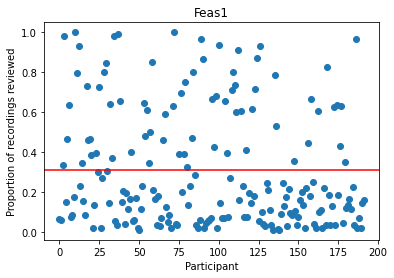

In [8]:
# Feas1
proportions = []
for pt_id in tqdm(feas1_id_list):
    list_all_reviewed_rec_indices = feas1_key_all_rec_for_each_pt[pt_id]["reviewed"]
    list_all_unreviewed_rec_indices = feas1_key_all_rec_for_each_pt[pt_id]["unreviewed"]
    
    if len(list_all_reviewed_rec_indices) > 0:    
        no_all_rec_for_pt = len(list_all_reviewed_rec_indices) + len(list_all_unreviewed_rec_indices)
        proportions.append([pt_id, len(list_all_reviewed_rec_indices) / no_all_rec_for_pt])

mean_value = np.mean(np.array(proportions).T[1])
plt.axhline(y=mean_value, color='r', linestyle='-', label="mean")        
plt.scatter(np.arange(len(proportions)),np.array(proportions).T[1])
plt.ylabel("Proportion of recordings reviewed")
plt.xlabel("Participant")
plt.title("Feas1")

100%|████████████████████████████████████████████████████████████| 287/287 [00:00<00:00, 287226.26it/s]


Text(0.5, 1.0, 'Feas2')

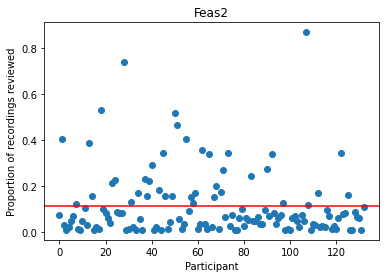

In [9]:
# Feas2
proportions = []
for pt_id in tqdm(feas2_id_list):
    list_all_reviewed_rec_indices = feas2_key_all_rec_for_each_pt[pt_id]["reviewed"]
    list_all_unreviewed_rec_indices = feas2_key_all_rec_for_each_pt[pt_id]["unreviewed"]
    
    if len(list_all_reviewed_rec_indices) > 0:    
        no_all_rec_for_pt = len(list_all_reviewed_rec_indices) + len(list_all_unreviewed_rec_indices)
        proportions.append([pt_id, len(list_all_reviewed_rec_indices) / no_all_rec_for_pt])

mean_value = np.mean(np.array(proportions).T[1])
plt.axhline(y=mean_value, color='r', linestyle='-', label="mean")  
plt.scatter(np.arange(len(proportions)),np.array(proportions).T[1])
plt.ylabel("Proportion of recordings reviewed")
plt.xlabel("Participant")
plt.title("Feas2")